# The Wilson-Cowan model

In this notebook, the basic use of the implementation of the Wilson-Cowan (`wc`) model is presented. 

In the `wc` model, the activity of a particular brain region is defined by a coupled system of excitatory (E) and inhibitory (I) neuronal populations with the mean firing rates of the E and I pools being the dynamic variables, as first described by Wilson and Cowan in 1972 ( H.R. Wilson and J.D. Cowan. *Excitatory and inhibitory interactions in localized populations of model neurons*. Biophys. J., 12:1–24 (1972)) 

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
# get the current directory
cwd = os.getcwd()


# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: /Users/masha/Documents/Uni/Thesis/neurolib


In [2]:
from neurolib.models.wc import WCModel
# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.wc import WCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [5]:
wc = WCModel()
wc.params['duration'] = 2.0*1000

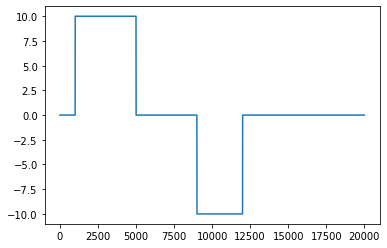

In [8]:
stimulus = np.zeros((20000))
stimulus[1000:5000] = 5
stimulus[9000:12000] = -5
plt.plot(stimulus)

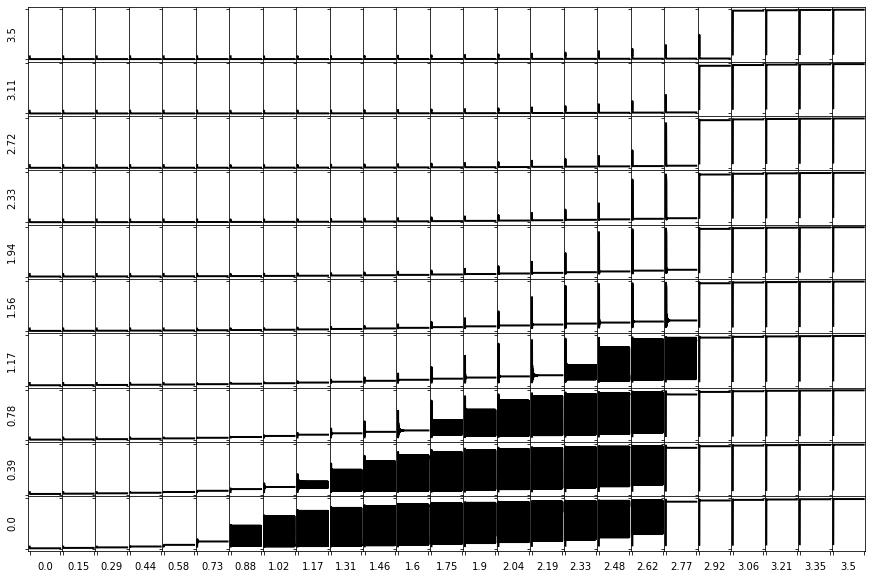

In [11]:
max_exc = []
min_exc = []
ex = []
wc.params["control_term"] = stimulus
# these are the different input values that we want to scan
exc_inputs_n = 25
inh_inputs_n = 10
exc_inputs = np.linspace(0, 3.5, exc_inputs_n)
inh_inputs = np.linspace(0, 3.5, inh_inputs_n)
fig,a =  plt.subplots(10,25,  sharex='col', sharey='row', figsize=(15,10))
for i, inh_ext in enumerate(inh_inputs):
    for j, exc_ext in enumerate(exc_inputs):
        # Note: this has to be a vector since it is input for all nodes
        # (but we have only one node in this example)
        wc.params['exc_ext'] = exc_ext
        wc.params['inh_ext'] = inh_ext
        wc.run()
        # we add the maximum and the minimum of the last second of the 
        # simulation to a list
        max_exc.append(np.max(wc.exc[0, -int(1000/wc.params['dt']):]))
        min_exc.append(np.min(wc.exc[0, -int(1000/wc.params['dt']):]))
        #print(np.shape(wc.exc))
        ex = wc.exc


        #plt.figure(figsize = (20, 6))
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()
        
        
        #fig, ax = plt.subplots(50, 50, sharex='col', sharey='row')

        #ax[i, j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        
        
        
        a[inh_inputs_n-i-1][j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #a[9-i][j].plot(s)

        # Turn off tick labels
        a[inh_inputs_n-i-1][j].set_yticklabels([])
        a[inh_inputs_n-i-1][j].set_xticklabels([])
        
        if(i==0):
            a[inh_inputs_n-i-1][j].set_xlabel(round(exc_ext, 2))
        if(j==0):
            a[inh_inputs_n-i-1][j].set_ylabel(round(inh_ext, 2))
       

        #plt.show()

        #ex = wc.inh
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()

        #print(np.shape(wc.bracets))
        #plt.plot(wc.params['duration']/wc.params['dt'], wc.exc[0], c='k', lw = 2)
        #plt.show()

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)
#fig.tight_layout()
plt.show()

In [21]:
def optimal_control(wс,stimulus, exc_exp, inh_exp):
    
    #h = (xn-x0)/n_step
    #times = np.arange(0, xn+h, h)
    times = range(int(wc.params['duration']/wc.params['dt']))
    #print(times)
    u_i = stim.StepInput(step_size=0,  start=5, end=100, n=1).to_model(wc)
    u_e = stim.StepInput(step_size=0,  start=5, end=100, n=1).to_model(wc)
    step_size = 10
    for l in range(50):

        wc.params["control_term_E"] = u_e
        wc.params["control_term_I"] = u_i

        
        wc.run()
        ex = wc.exc
        inh = wc.inh
        
        print(np.shape(ex))
        
        print(int(wc.params['duration']/wc.params['dt']))
        
        
        plt.figure(figsize = (20, 6))
        plt.plot(target.T,c = 'blue')
        plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        plt.show()
        
        
        lambdas = euler_backwards(wc, exc_exp, inh_exp, 0.1, int(wc.params['duration']/wc.params['dt']))
        
        w = [0,0]
        
        grad = grad_f(w, u_e,u_i, lambdas)
        
        step_size_adj = 0.005
        
        #if l == 0:
        #    step_size_adj = bisection(wc, step_size,u_e,u_i,grad, times, exc_exp)
            
        u_e = u_e-step_size_adj*np.array(grad[0])
        u_i = u_i-step_size_adj*np.array(grad[1])

            
            

In [13]:
def bisection(model, step_size, u_e, u_i, grad, times, exc_exp):
    cost_temp = 10**12
    while step_size > 0.00001:
        u_e = u_e-step_size*np.array(grad[0])
        u_i = u_i-step_size*np.array(grad[1])

        model.params["control_term_E"] = u_e
        model.params["control_term_I"] = u_i


        wc.run()
        ex = model.exc
        inh = model.inh

        cost = cost_f(ex[0], exc_exp, u_e, u_i, times)
        #print("cost", cost)
        #step_size = step_size/2
        #cost_temp = cost
        if(cost<cost_temp):
            step_size = step_size/2
            cost_temp = cost
        else:
            return step_size
        
    return 0.00001
        

def cost_f(x, x_, u_exc, u_inh, times):
    return  0.3 * (np.sqrt(scipy.integrate.simps(u_exc**2, times)) \
            + np.sqrt(scipy.integrate.simps(u_inh**2, times)) \
            + 0.5 * scipy.integrate.simps(u_exc**2 + u_inh**2, times)) \
            +  0.5 * scipy.integrate.simps((x-x_)**2,times)

In [14]:
def S_E(x, model, i):
    a_exc = model.params["a_exc"]
    mu_exc = model.params["mu_exc"]
    return 1.0 / (1.0 + np.exp(-a_exc * (x[0][i] - mu_exc)))

def S_I(x, model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    return 1.0 / (1.0 + np.exp(-a_inh * (x[0][i] - mu_inh)))

def dh1_dE(model, i):
    a_exc = model.params["a_exc"]
    C_EE = model.params["c_excexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E
    E_j = model.exc[0][i]
    return -1-S_E(brackets_E, model,i)+(a_exc*np.exp(-a_exc * ( brackets_E[0][i] - mu_exc)))/(S_E(brackets_E, model,i)**2)*C_EE*(1-E_j)

def dh2_dE(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_II = model.params["c_inhinh"]
    brackets_I = model.brackets_I
    I_j = model.inh[0][i]
    return -1-S_I(brackets_I, model,i)+(a_inh*np.exp(-a_inh * (brackets_I[0][i] - mu_inh)))/(S_I(brackets_I, model,i)**2)*C_II*(1-I_j)

def dh1_dI(model, i):
    a_exc = model.params["a_exc"]
    C_IE = model.params["c_inhexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E
    E_j = model.exc[0][i]
    return (1-E_j)*(a_exc*np.exp(-a_exc * (brackets_E[0][i] - mu_exc)))/(S_E(brackets_E, model,i)**2)*(-C_IE)

def dh2_dI(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_EI = model.params["c_excinh"]
    brackets_I = model.brackets_I
    I_j = model.inh[0][i]
    return (1-I_j)*(a_inh*np.exp(-a_inh * (brackets_I[0][i] - mu_inh)))/(S_I(brackets_I, model,i)**2)*C_EI

    
def lambda_def(model, lambdas, ex_exp, inh_exp, i):
    
    tauE = model.params["tau_exc"]
    tauI = model.params["tau_inh"]
    
    Dx_doth = np.array([[ -tauE, 0], 
                  [0, -tauI]])
    
    Dxf = np.array([ model.exc[0][i]-ex_exp[i], model.inh[0][i]-inh_exp[i]])
    
    Dxh = np.array([[ dh1_dE(model,i), dh1_dI(model, i)], 
                  [dh2_dE(model, i), dh2_dI(model, i)]])
    
    return (Dxf - lambdas[i]@Dxh)@np.linalg.inv(Dx_doth)

def euler_backwards(model, ex_exp, inh_exp, step, n):
     
    lambdas = [[0,0] for i in range(n)]
    
    inh = wc.inh[0]
    ex = wc.exc[0]
    
    for i in range(n-2,-1,-1):
        lambdas[i] = lambdas[i+1]-step*lambda_def(model, lambdas, ex_exp, inh_exp, i)

    return lambdas

def grad_f(w, u_e, u_i, lambdas): ##TODO add cost components
    return [[x[0] for x in lambdas],[x[1] for x in lambdas]] + [0*u_e, 0*u_i]
    

In [15]:
wc = WCModel()
wc.params['duration'] = 2.0*1000

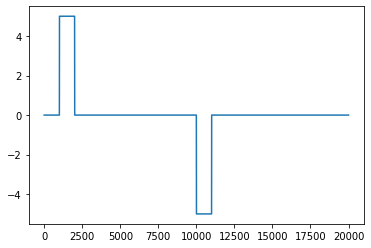

In [186]:
#stimulus
stimulus = np.zeros((20000))
stimulus[1000:2000] = 5
stimulus[10000:11000] = -5
plt.plot(stimulus)

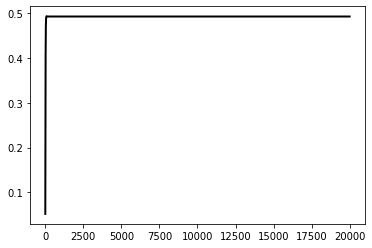

In [23]:
#target signal


wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 3.5
wc.params['inh_ext'] = 3.5
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
#plt.plot(s)
plt.show()
target = wc.exc


#target = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
#plt.plot(target.T)

In [179]:
wc.params["control_term"] = stimulus

(1, 20000)
20000


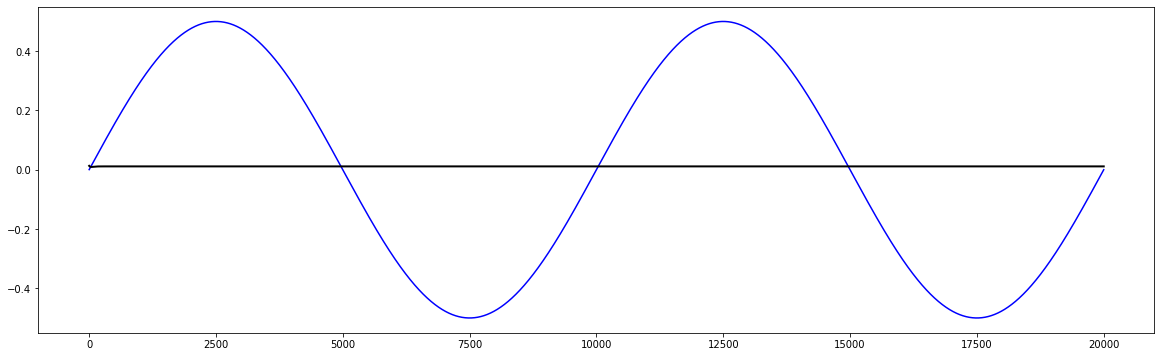

(1, 20000)
20000


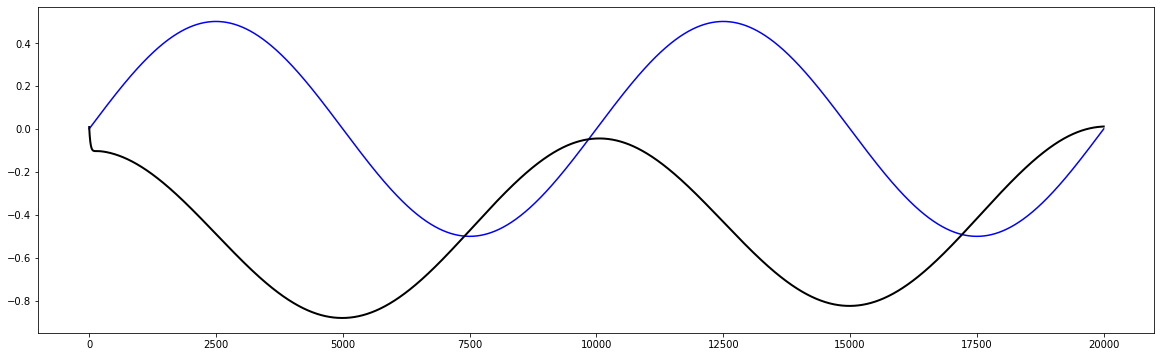

(1, 20000)
20000


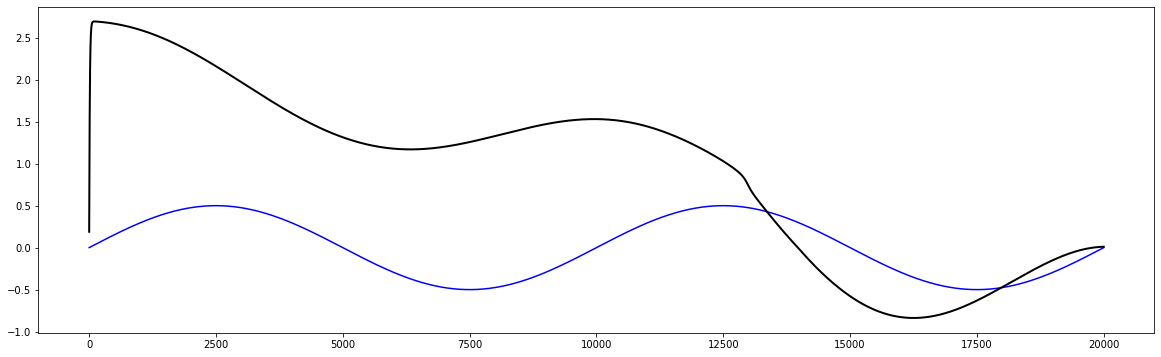

(1, 20000)
20000


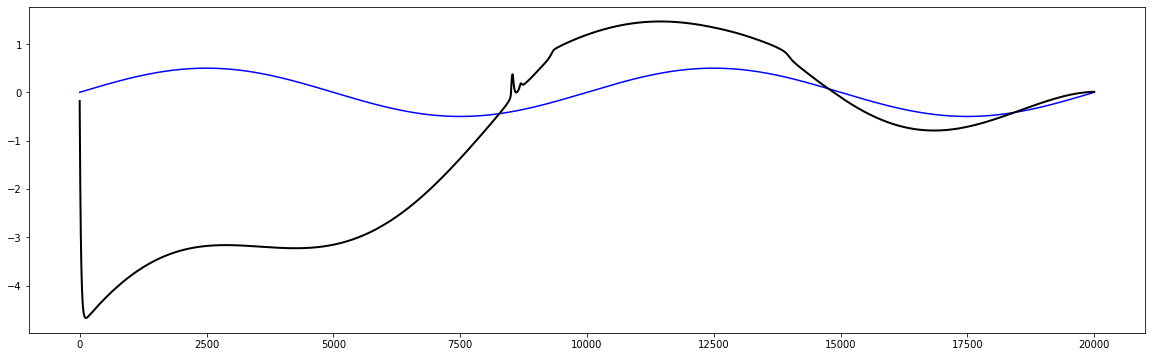

(1, 20000)
20000


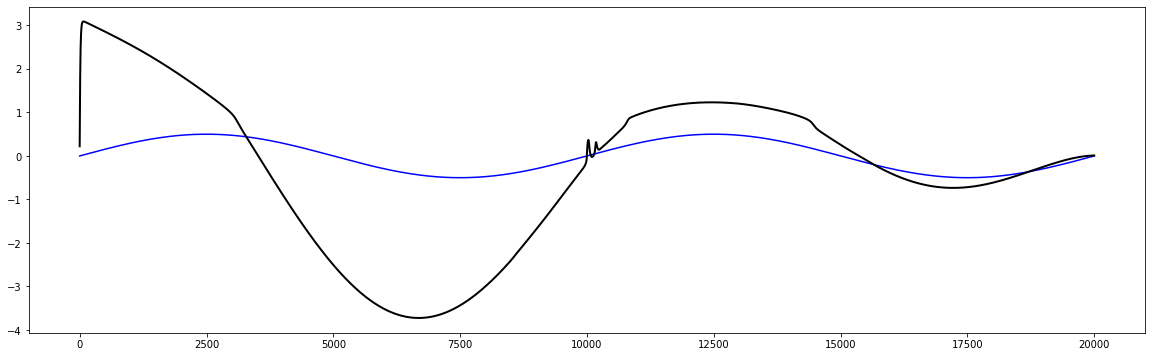

(1, 20000)
20000


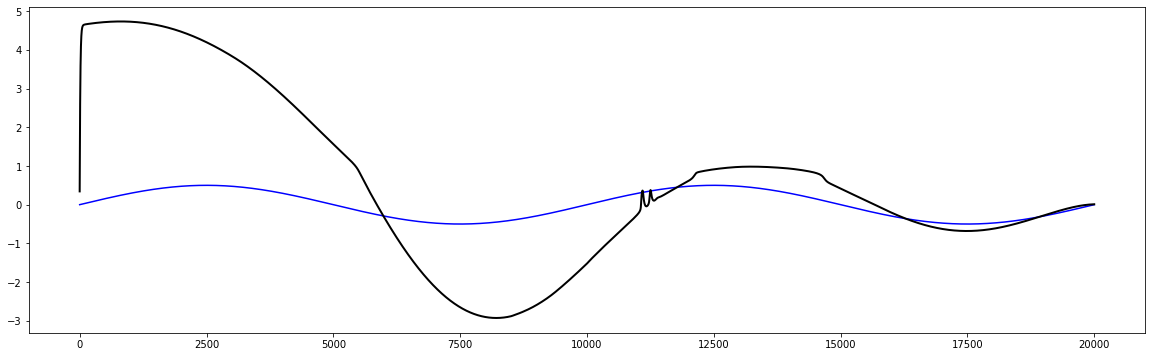

(1, 20000)
20000


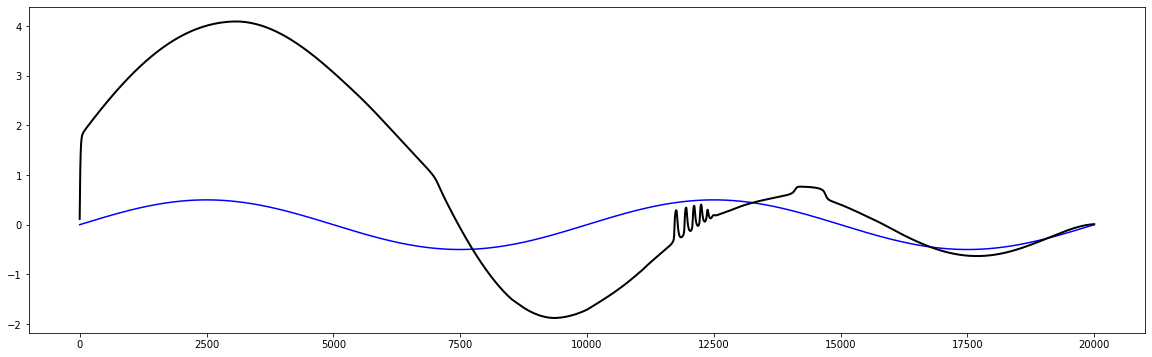

(1, 20000)
20000


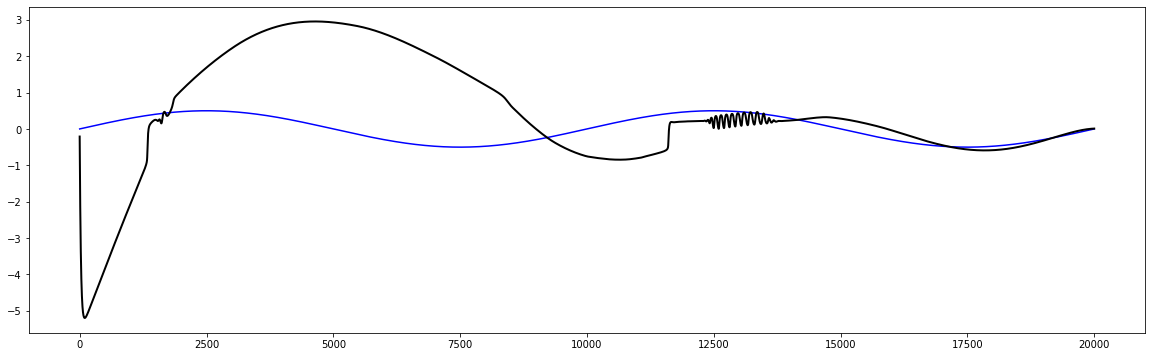

(1, 20000)
20000


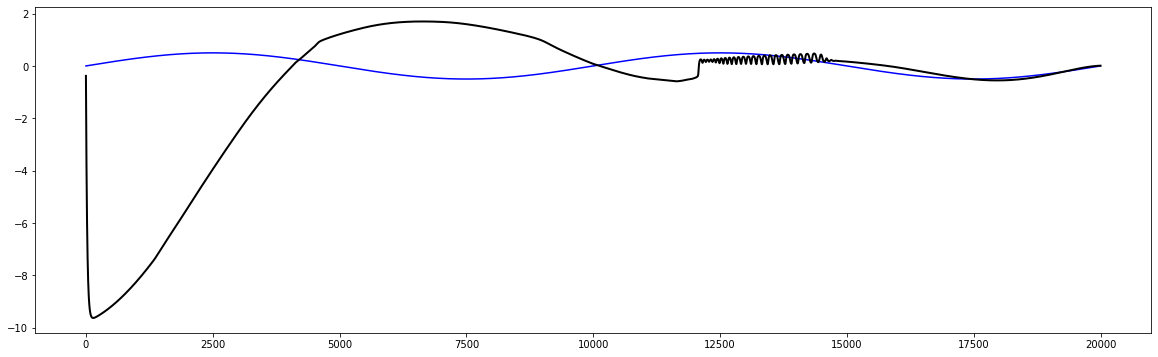

(1, 20000)
20000


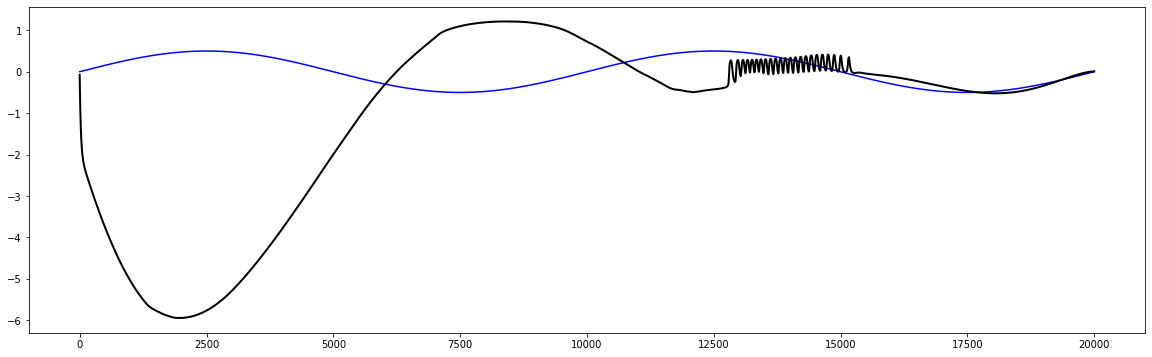

(1, 20000)
20000


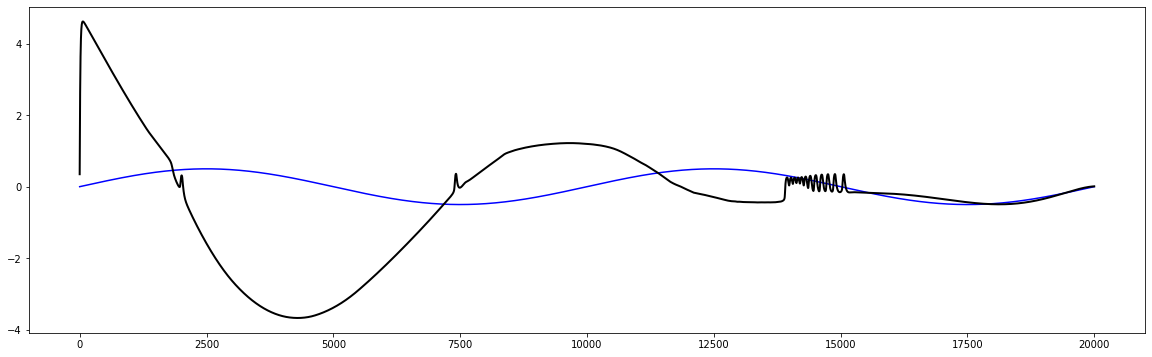

(1, 20000)
20000


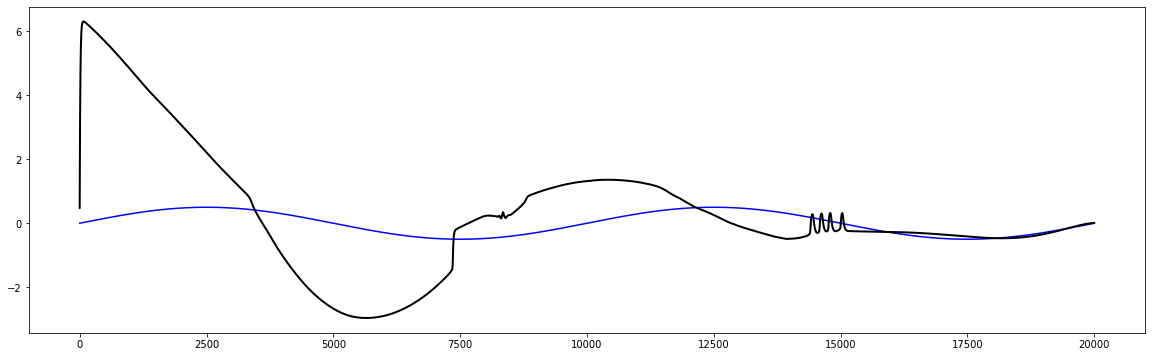

(1, 20000)
20000


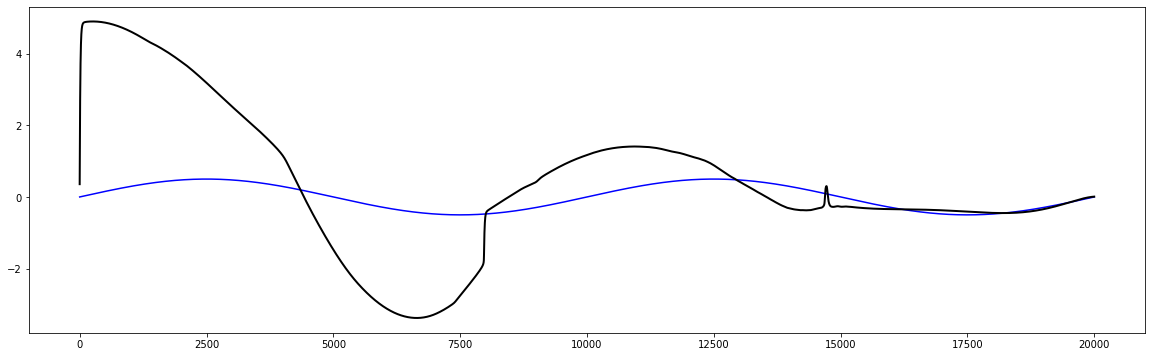

(1, 20000)
20000


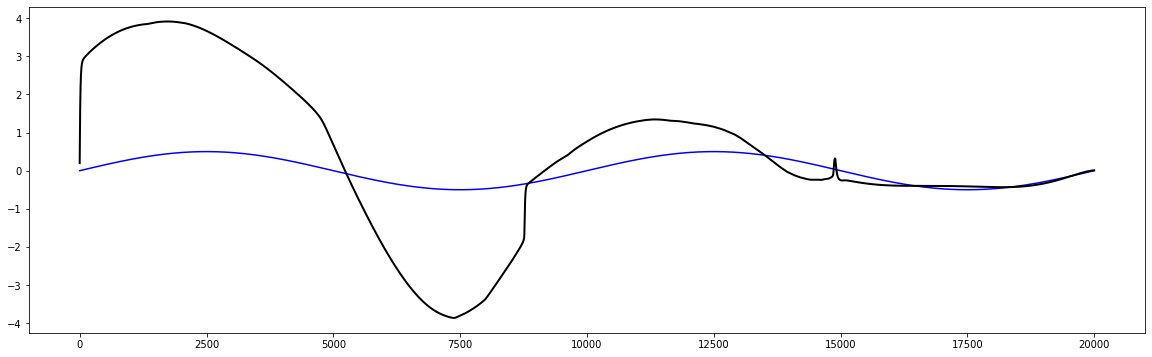

(1, 20000)
20000


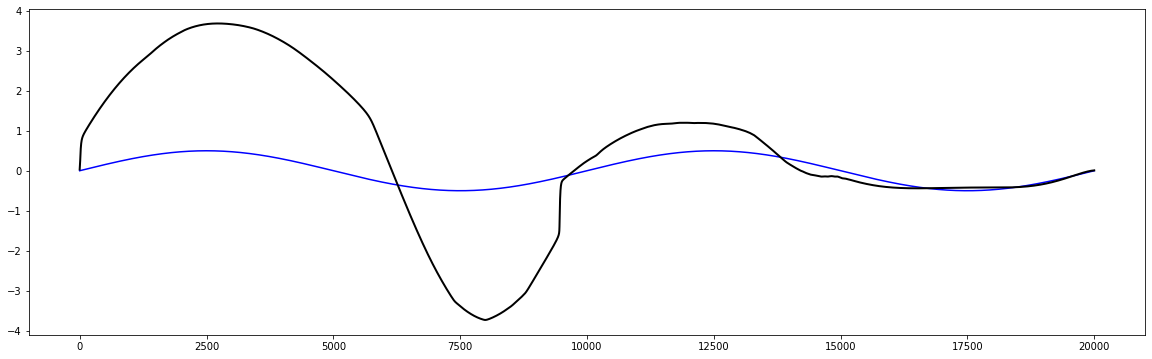

(1, 20000)
20000


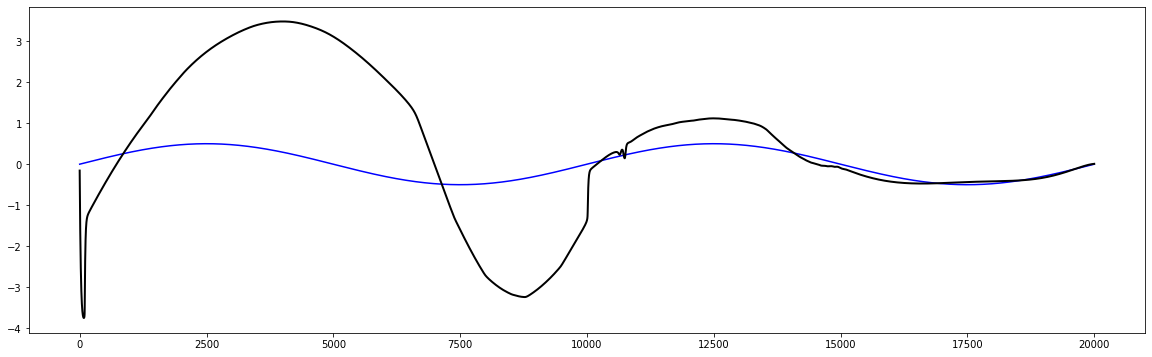

(1, 20000)
20000


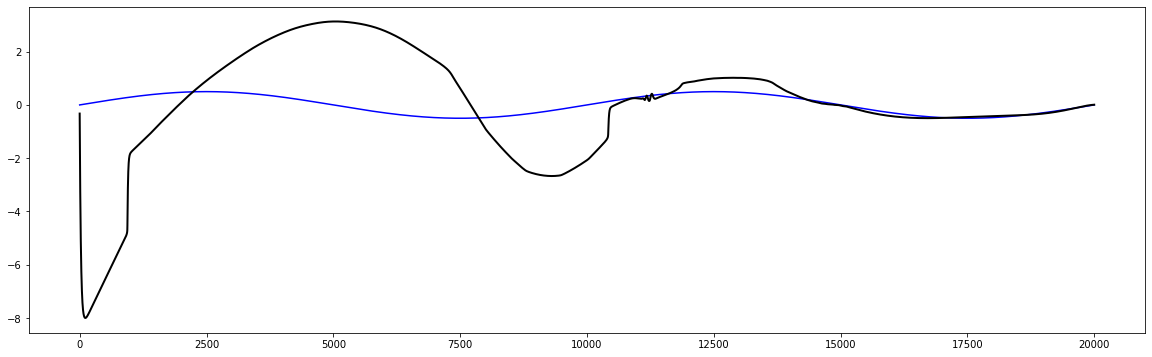

(1, 20000)
20000


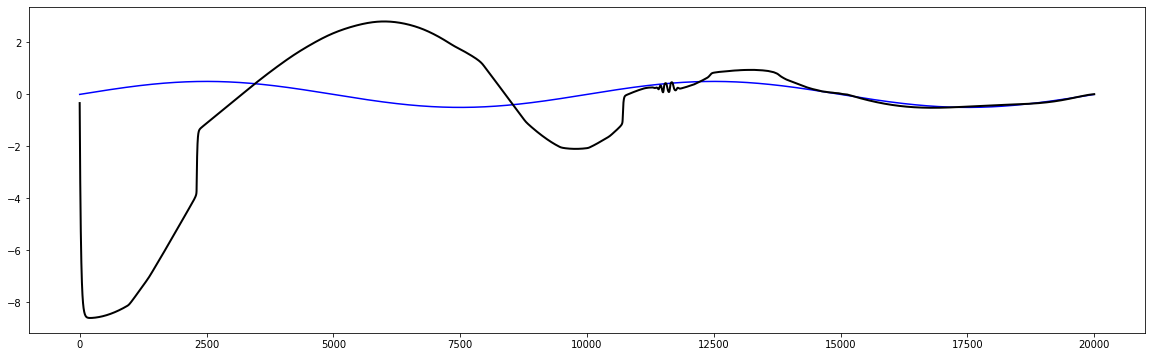

(1, 20000)
20000


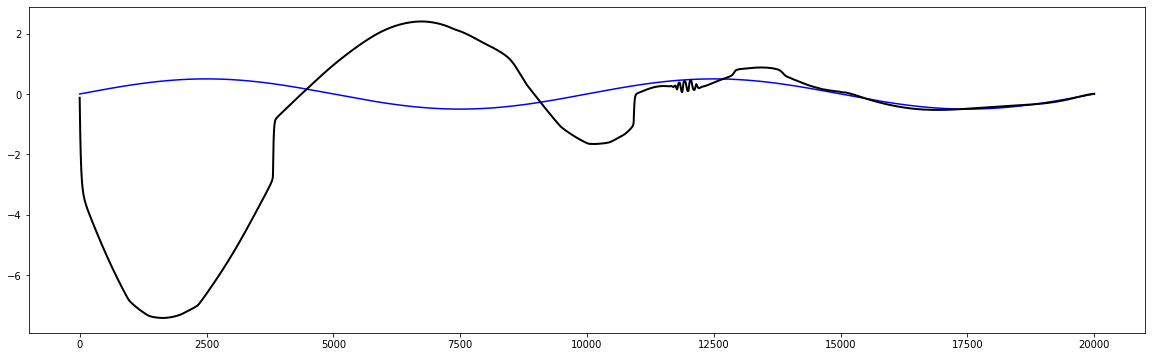

(1, 20000)
20000


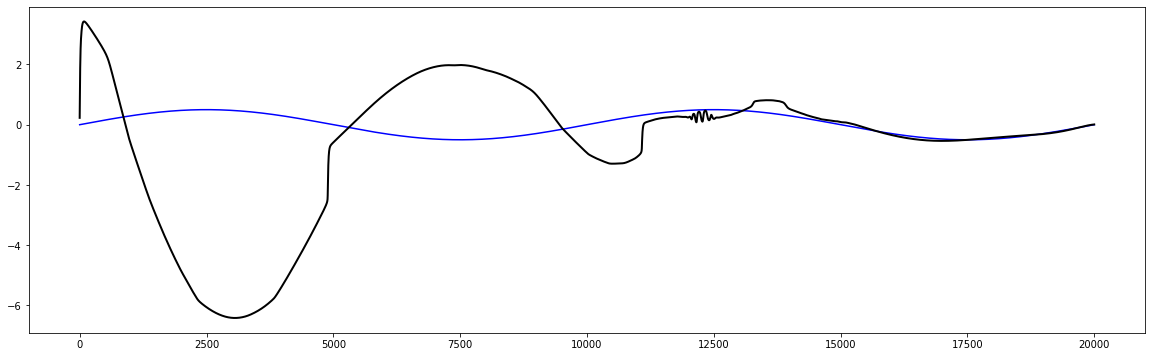

(1, 20000)
20000


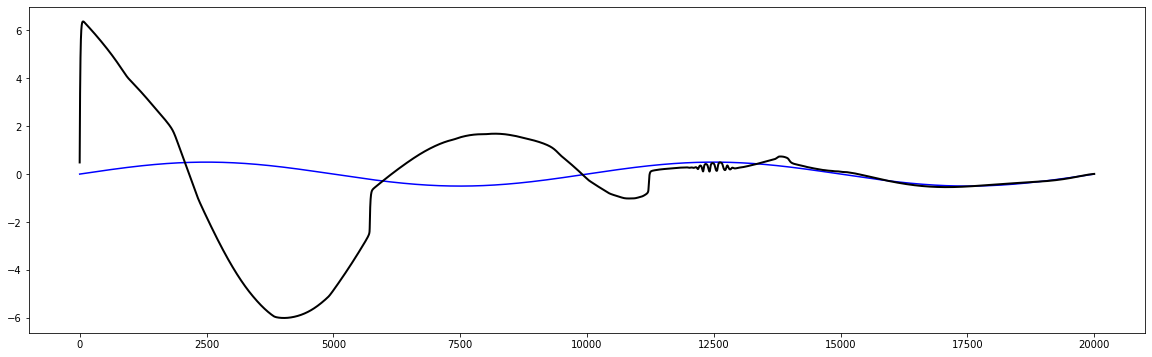

(1, 20000)
20000


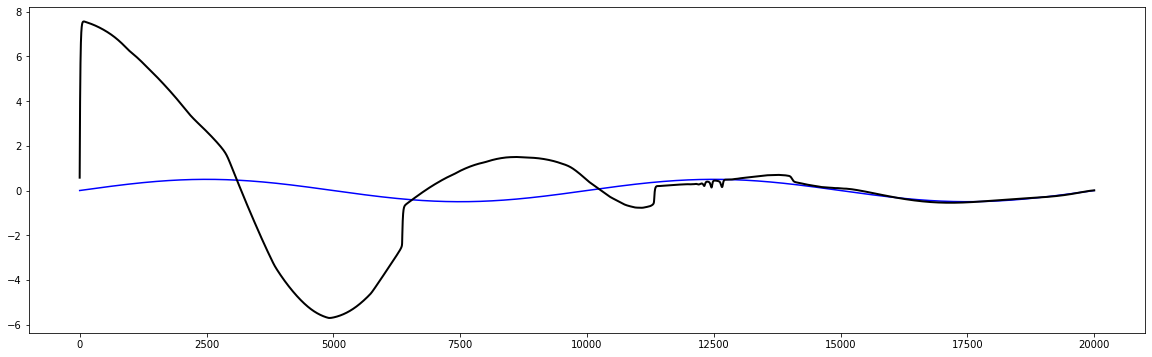

(1, 20000)
20000


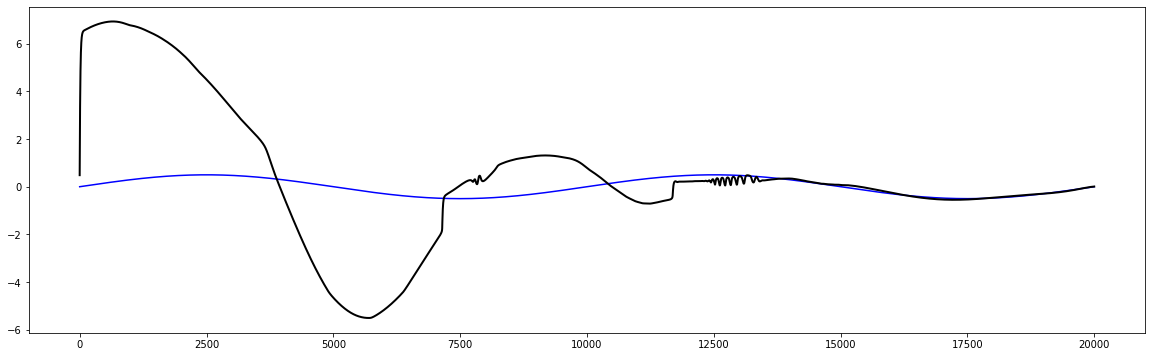

(1, 20000)
20000


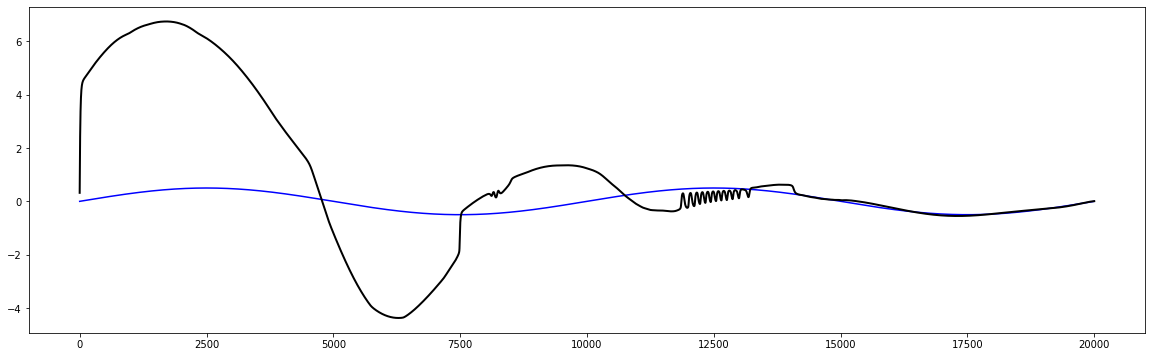

(1, 20000)
20000


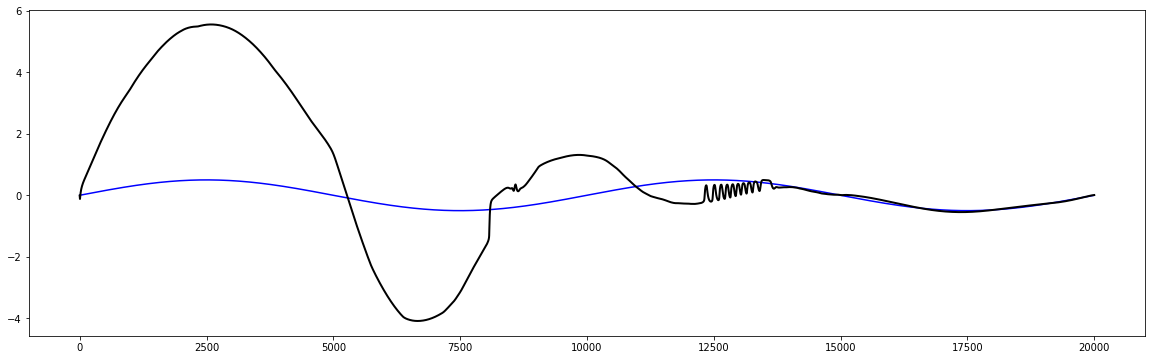

(1, 20000)
20000


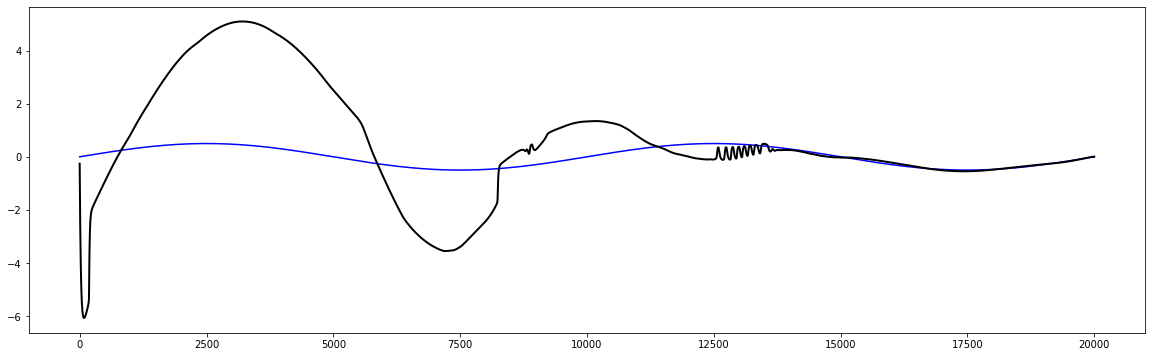

(1, 20000)
20000


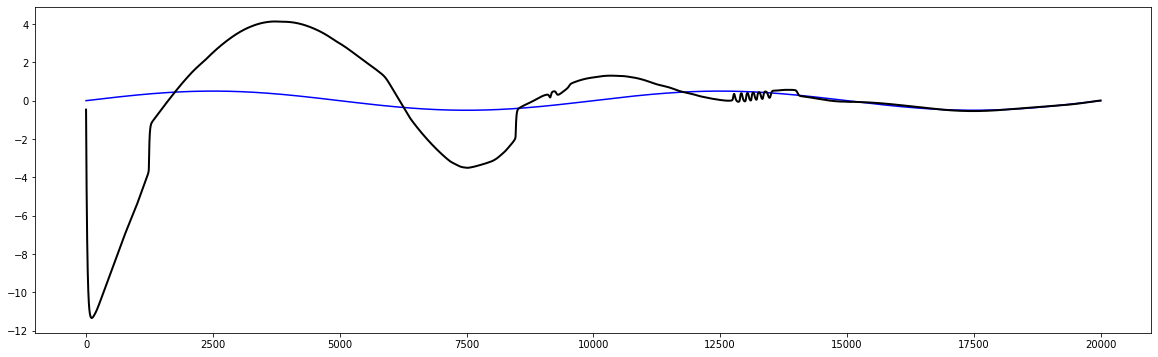

(1, 20000)
20000


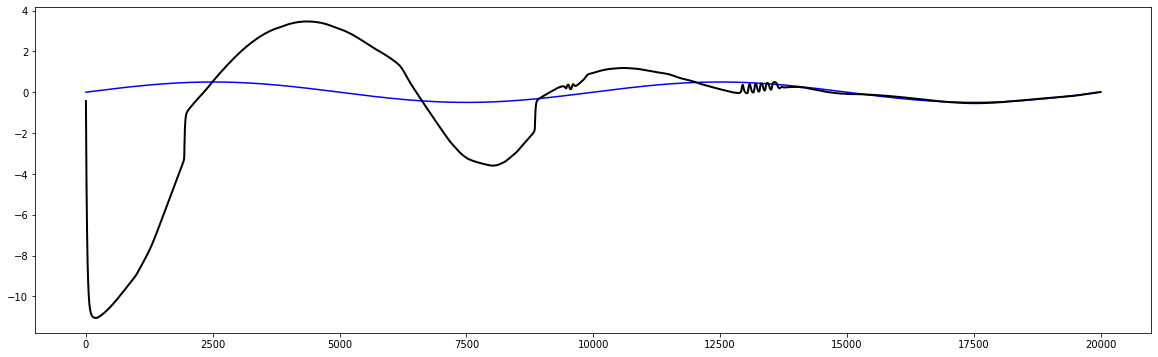

(1, 20000)
20000


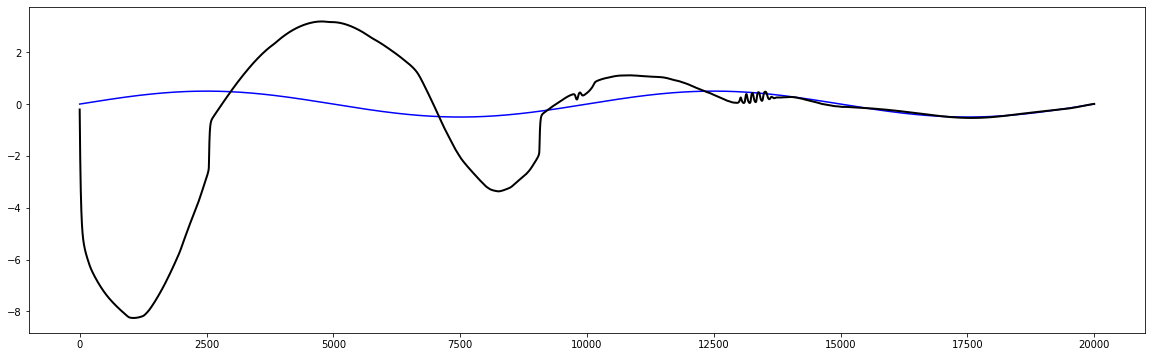

(1, 20000)
20000


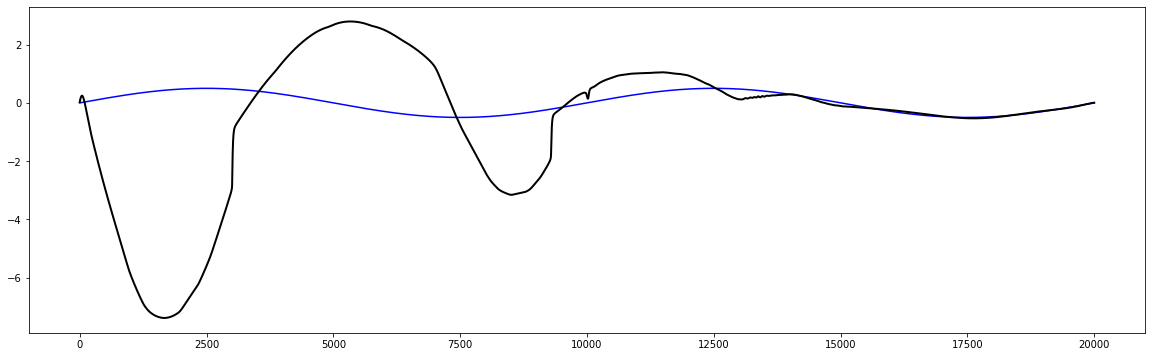

(1, 20000)
20000


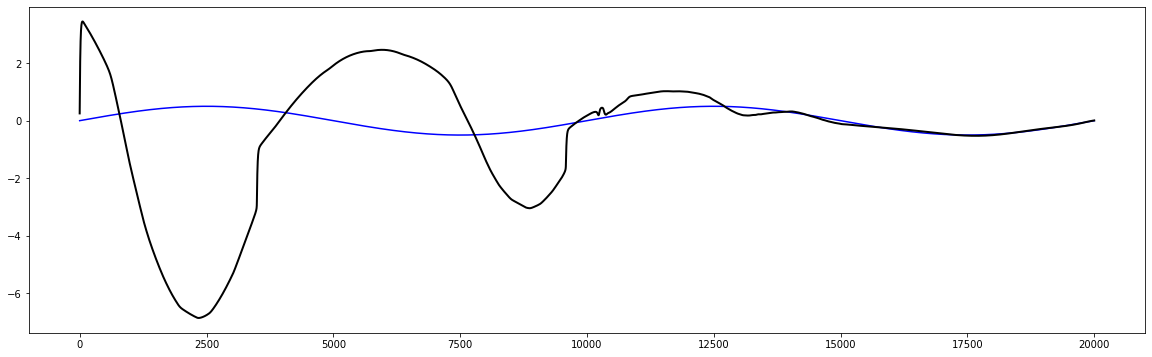

(1, 20000)
20000


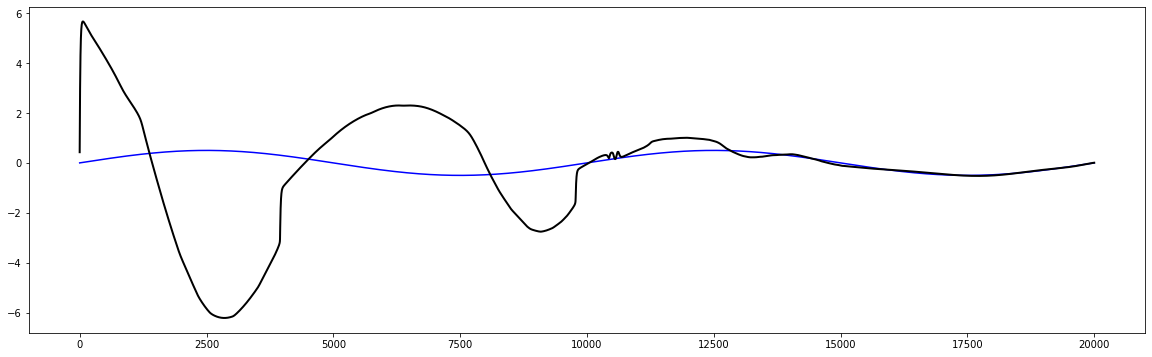

(1, 20000)
20000


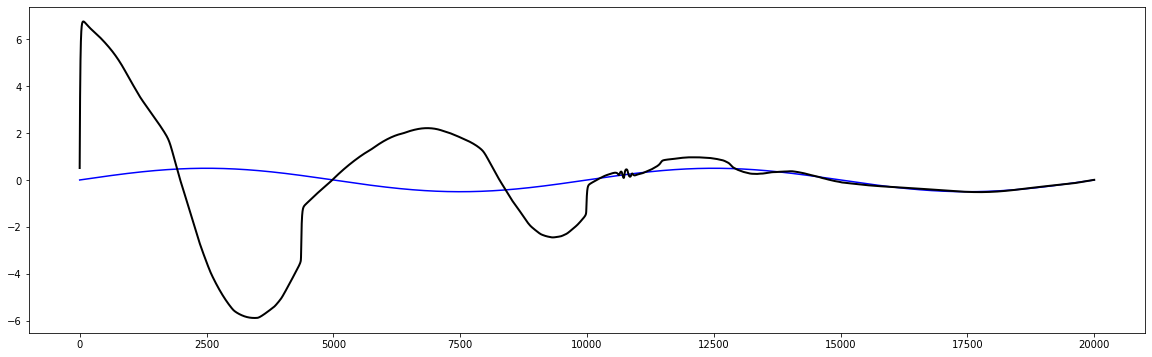

(1, 20000)
20000


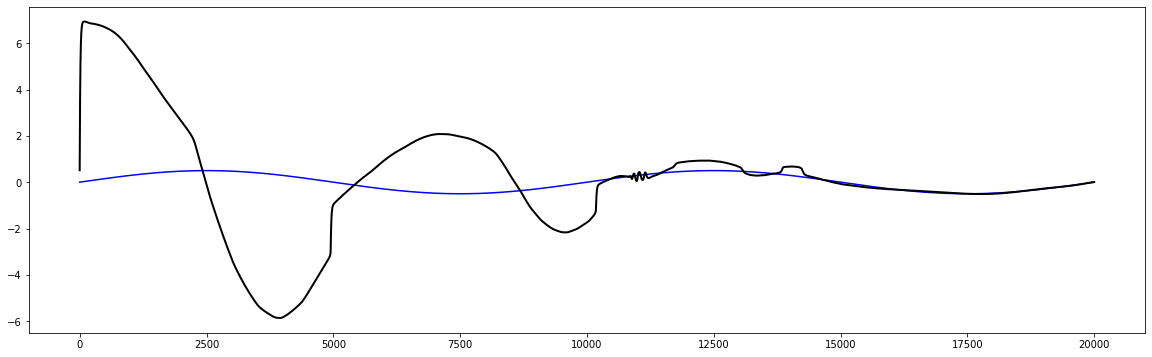

(1, 20000)
20000


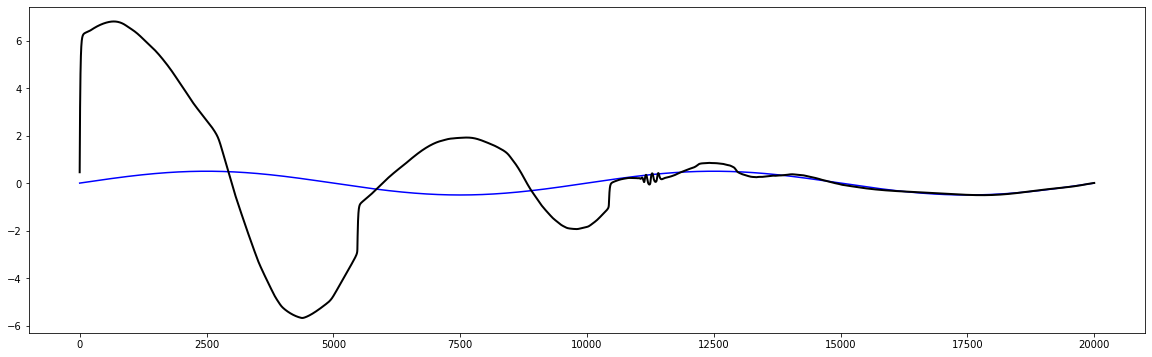

(1, 20000)
20000


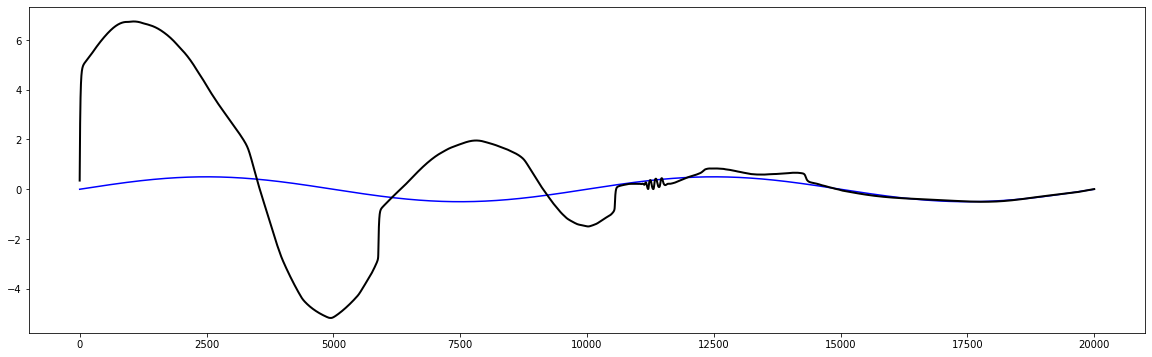

(1, 20000)
20000


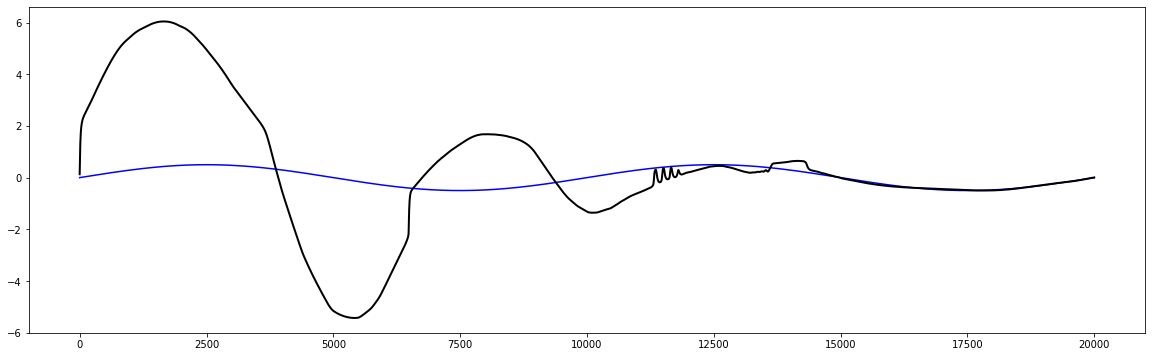

(1, 20000)
20000


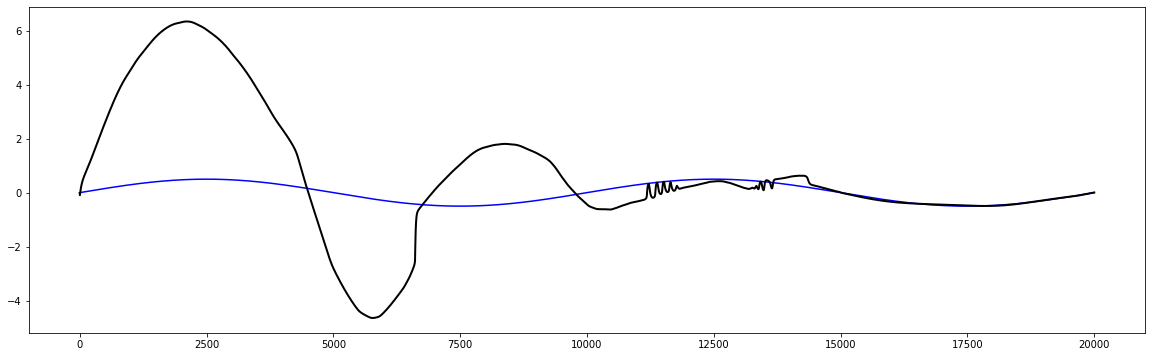

(1, 20000)
20000


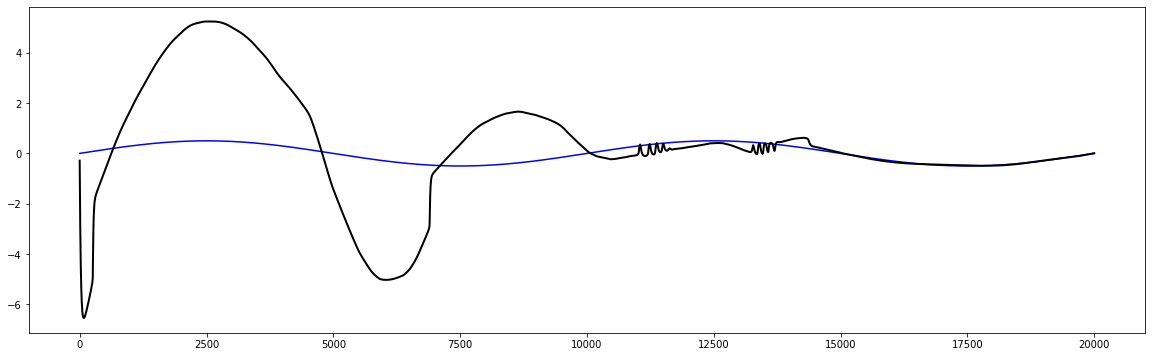

(1, 20000)
20000


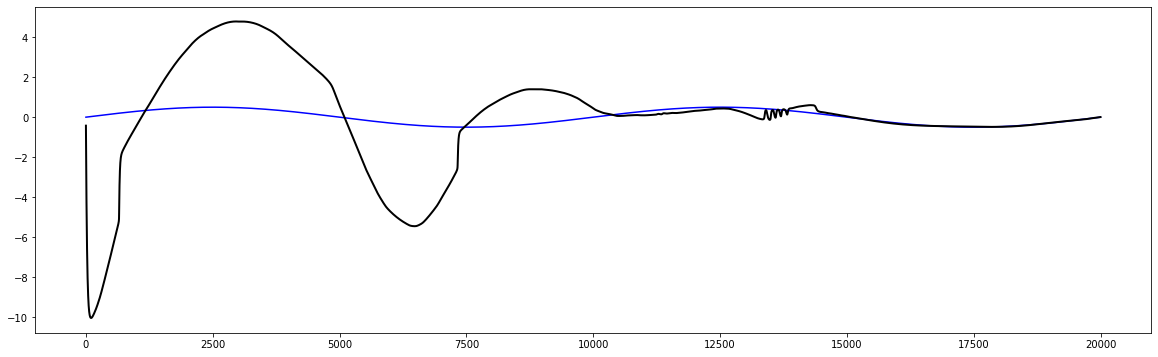

(1, 20000)
20000


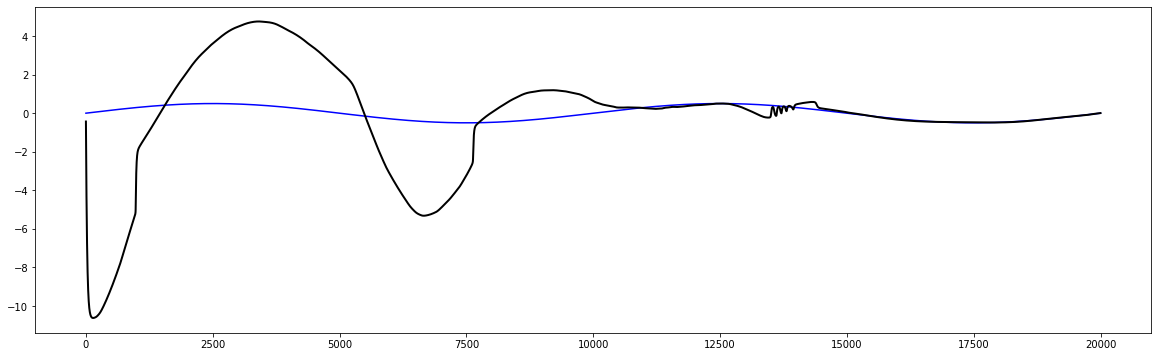

(1, 20000)
20000


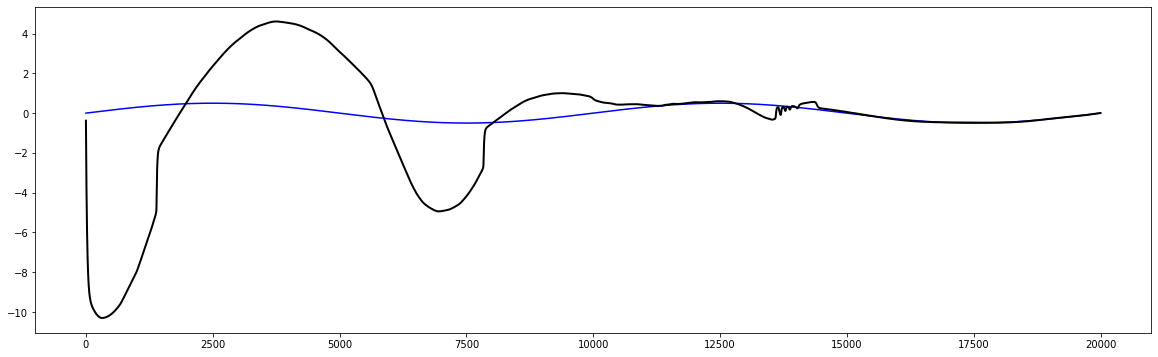

(1, 20000)
20000


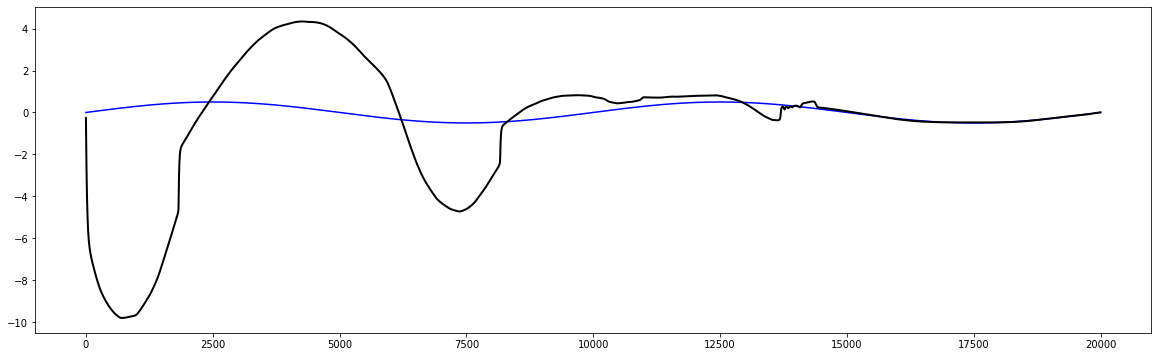

(1, 20000)
20000


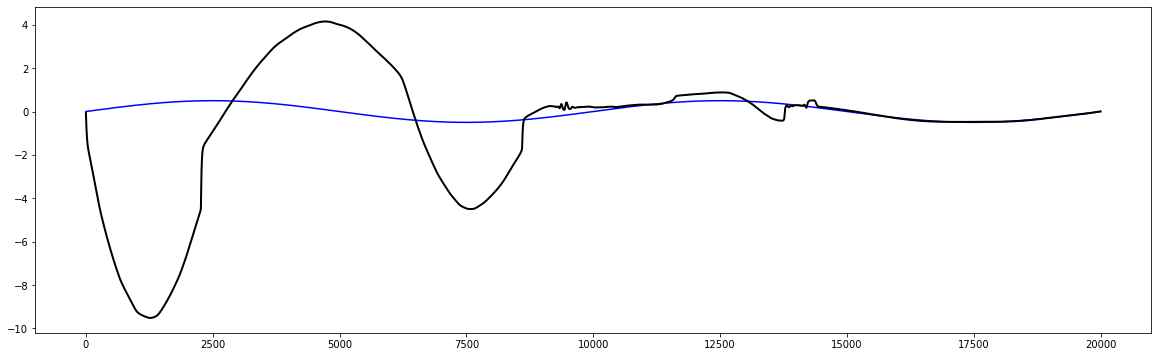

(1, 20000)
20000


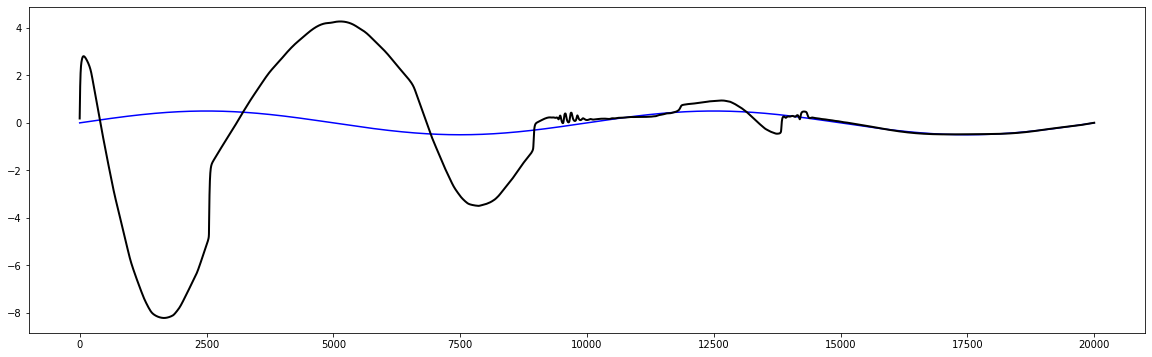

(1, 20000)
20000


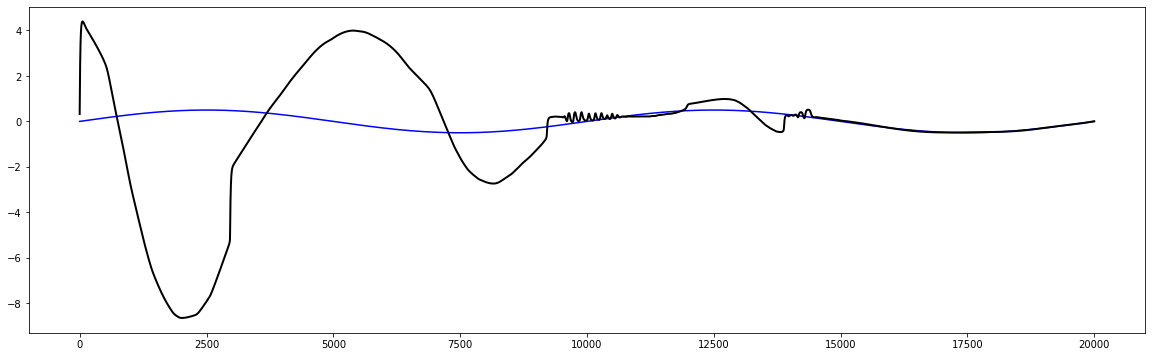

(1, 20000)
20000


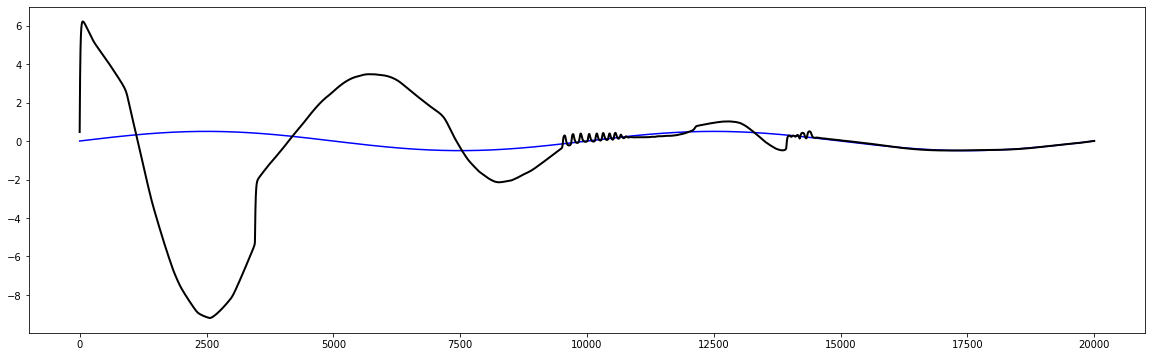

(1, 20000)
20000


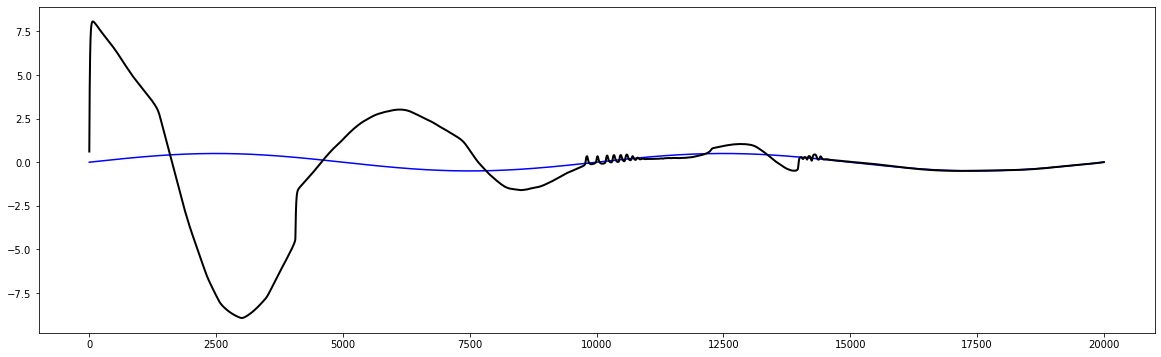

(1, 20000)
20000


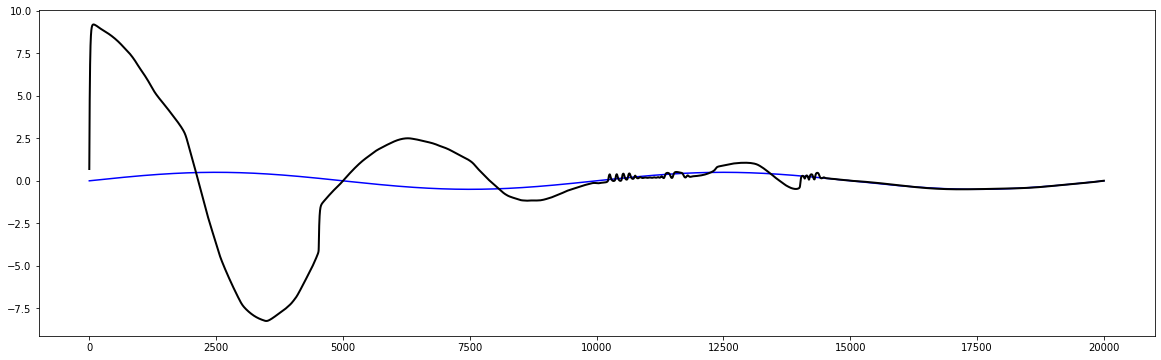

(1, 20000)
20000


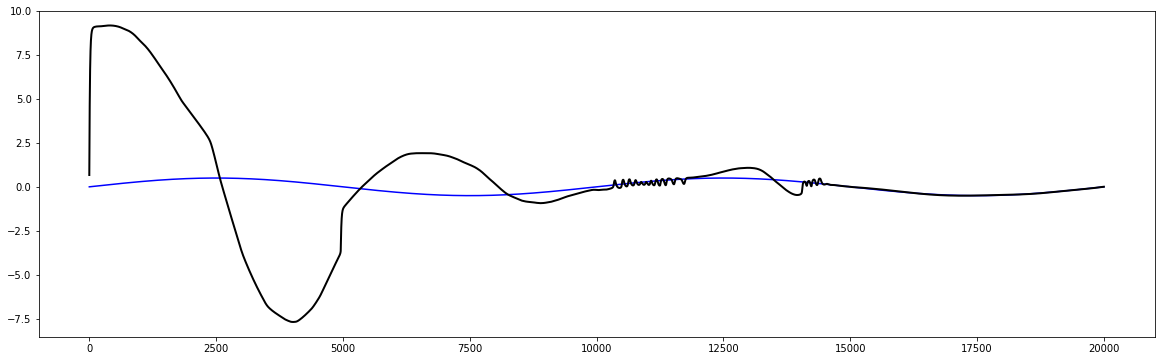

In [22]:
optimal_control(wc, stimulus, target[0], target[0])
#optimal_control(wc, stimulus, target, target)

## Drafts

In [168]:
wc.params['exc_ext'] = 3.5
wc.params['inh_ext'] = 3.5
wc.run()

ERROR:root:nan in model output!


(1, 20000)


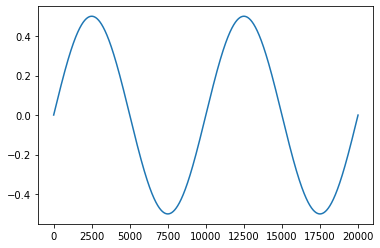

In [156]:
stimulus = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
print(stimulus.shape)
plt.plot(stimulus.T)
wc.params["control_term"] = stimulus

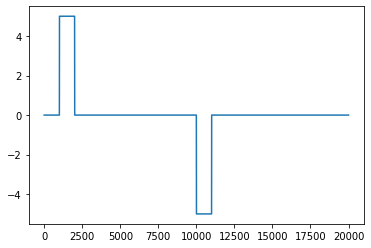

In [196]:
stimulus = np.zeros((20000))
stimulus[1000:2000] = 5
stimulus[10000:11000] = -5
plt.plot(stimulus)

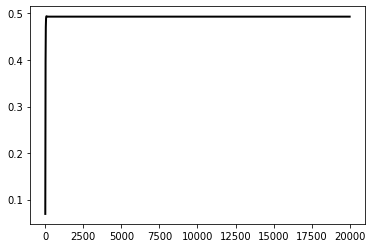

In [182]:
wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 3.5
wc.params['inh_ext'] = 3.5
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
#plt.plot(s)
plt.show()
target = wc.exc[0]


In [ ]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")

In [ ]:
def dh1_dE():
    return 1

def dh2_dE():
    return 2

def dh1_dI():
    return 3

def dh2_dI():
    return 4

def df_dE():
    return 0

def df_dI():
    return 0

lambd1 = 1
lambd2 = 2
Dxh = np.array([[ dh1_dE(), dh1_dI()], 
                  [dh2_dE(), dh2_dI()]])
lambdas = np.array([lambd1, lambd2])

Dxf = np.array([df_dE(), df_dI()])

tauE = 2
tauI = 8

Dx_doth = np.array([[ -tauE, 0], 
                  [0, -tauI]])
x = np.linalg.solve(Dx_doth, b)

(Dxf - lambdas@Dxh)@np.linalg.inv(Dx_doth)



In [ ]:
exp = stim.SinusoidalInput(amplitude=0.5, frequency=0.5).to_model(wc)
#exp = stim.StepInput(step_size=0.5, start=10, end=80, n=2).to_model(wc)
plt.plot(exp.T)

## Single node simulation

In [ ]:
wc = WCModel()
wc.params['duration'] = 1.0*1000
wc.params['sigma_ou'] = 0.01

wc.run()

In [ ]:
plt.plot(wc.t, wc.exc.T, c='k', lw = 2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")

## Brain network

In [ ]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [ ]:
wc = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

In [ ]:
wc.params['exc_ext'] = 0.65

wc.params['signalV'] = 0
wc.params['duration'] = 20 * 1000 
wc.params['sigma_ou'] = 0.14
wc.params['K_gl'] = 3.15


wc.run(chunkwise=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(func.fc(wc.exc[:, -10000:]))
axs[1].plot(wc.t, wc.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)

In [ ]:
scores = [func.matrix_correlation(func.fc(wc.exc[:, -int(5000/wc.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))